In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
tf.__version__

'2.13.0'

# Specify each path

In [3]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [4]:
NUM_CLASSES = 10

# Dataset reading


## Giá trị của dữ liệu

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

## Nhãn của dữ liệu

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

## Chia tập dữ liệu

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 1180 (4.61 KB)
Trainable params: 1180 (4.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
71/73 [============================>.] - ETA: 0s - loss: 2.1274 - accuracy: 0.2596 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
73/73 [==============================] - 1s 3ms/step - loss: 2.1258 - accuracy: 0.2601 - val_loss: 1.8411 - val_accuracy: 0.4543
Epoch 2/1000
 1/73 [..............................] - ETA: 0s - loss: 1.8537 - accuracy: 0.3438
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
73/73 [==============================] - 0s 1ms/step - loss: 1.7390 - accuracy: 0.3989 - val_loss: 1.3684 - val_accuracy: 0.6889
Epoch 3/1000
 1/73 [..............................] - ETA: 0s - loss: 1.4707 - accuracy: 0.5391
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
73/73 [==============================] - 0s 1ms/step - loss: 1.3889 - accuracy: 0.5202 - val_loss: 1.0498 - val_accuracy: 0.7387
Epoch 4/1000
 1/73 [..............................] - ETA: 0s - loss: 1.4667 - accuracy: 0.42

In [13]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

25/25 [==============================] - 0s 500us/step - loss: 0.0570 - accuracy: 0.9945


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 42ms/step
[2.2425025e-25 1.5744855e-24 0.0000000e+00 9.9984682e-01 3.7851944e-09
 1.2797032e-13 8.5231285e-30 1.4722129e-04 1.1818164e-30 5.9415224e-06]
3


# Confusion matrix

97/97 [==============================] - 0s 359us/step


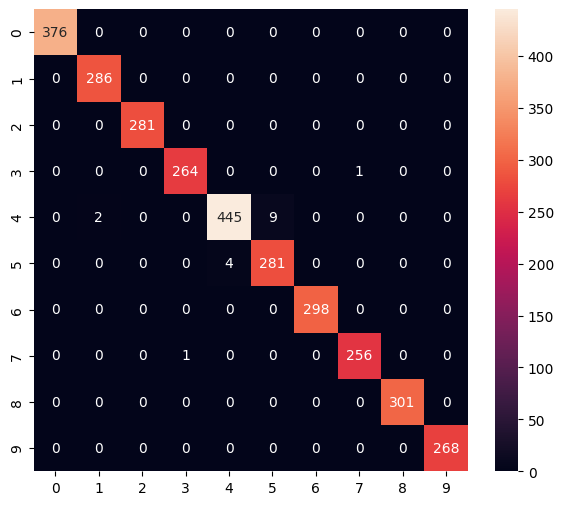

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       376
           1       0.99      1.00      1.00       286
           2       1.00      1.00      1.00       281
           3       1.00      1.00      1.00       265
           4       0.99      0.98      0.98       456
           5       0.97      0.99      0.98       285
           6       1.00      1.00      1.00       298
           7       1.00      1.00      1.00       257
           8       1.00      1.00      1.00       301
           9       1.00      1.00      1.00       268

    accuracy                           0.99      3073
   macro avg       0.99      1.00      0.99      3073
weighted avg       0.99      0.99      0.99      3073



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
# model.save(model_save_path, include_optimizer=False)
model.save(model_save_path)

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [
#                 tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
#                 tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
#             ]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp7ob74vz6\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp7ob74vz6\assets


6808

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.2425109e-25 1.5744855e-24 0.0000000e+00 9.9984682e-01 3.7852086e-09
 1.2797055e-13 8.5231939e-30 1.4722184e-04 1.1818075e-30 5.9415224e-06]
3
